In [3]:
import requests
import time
import sys

# the base URL for the UniProt REST API
UNIPROT_API_URL = "https://rest.uniprot.org/uniprotkb/search"

# list of 48 official HGNC gene symbols for human nuclear receptors
HUMAN_NUCLEAR_RECEPTOR_GENES = sorted([
    "AR", "ESR1", "ESR2", "ESRRA", "ESRRB", "ESRRG", "HNF4A", "HNF4G",
    "NR0B1", "NR0B2", "NR1D1", "NR1D2", "NR1H2", "NR1H3", "NR1H4", "NR1I2",
    "NR1I3", "VDR", "NR2C1", "NR2C2", "NR2E1", "NR2E3", "NR2F1", "NR2F2",
    "NR2F6", "NR3C1", "NR3C2", "PGR", "NR4A1", "NR4A2", "NR4A3", "NR5A1",
    "NR5A2", "NR6A1", "PPARA", "PPARD", "PPARG", "RARA", "RARB", "RARG",
    "RORA", "RORB", "RORC", "RXRA", "RXRB", "RXRG", "THRA", "THRB"
])

def get_uniprot_id(gene_symbol):
    params = {
        'query': f'(gene:{gene_symbol}) AND (organism_id:9606) AND (reviewed:true)',
        'format': 'json',
        'fields': 'accession',
        'size': 1  # we need the top 1 result
    }

    try:
        response = requests.get(UNIPROT_API_URL, params=params, timeout=15)
        response.raise_for_status()  

        data = response.json()
        if data.get('results'):
            # extract the primary accession number from the first result
            return data['results'][0]['primaryAccession']
        else:
            return None
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching data for {gene_symbol}: {e}", file=sys.stderr)
        return None
    except Exception as e:
        print(f"An unexpected error occurred for {gene_symbol}: {e}", file=sys.stderr)
        return None


def main():
    # fetching UniProt IDs
    print("Fetching UniProt IDs for 48 human nuclear receptors...\n")
    
    receptor_uniprot_map = {}
    not_found_genes = []
    
    total_genes = len(HUMAN_NUCLEAR_RECEPTOR_GENES)

    for i, gene in enumerate(HUMAN_NUCLEAR_RECEPTOR_GENES):
        print(f"[{i+1}/{total_genes}] Searching for gene: {gene}...")
        uniprot_id = get_uniprot_id(gene)

        if uniprot_id:
            receptor_uniprot_map[gene] = uniprot_id
        else:
            print(f"  -> UniProt ID not found for {gene}")
            not_found_genes.append(gene)

        time.sleep(0.5)

    # saving the results
    output_filename = "nuclear_receptor_uniprot_ids.txt"
    print(f"\nFetching complete. Writing results to '{output_filename}'...")

    try:
        with open(output_filename, 'w', encoding='utf-8') as f:
            f.write("--- Human Nuclear Receptor UniProt ID Report ---\n")
            f.write(f"Successfully found IDs for {len(receptor_uniprot_map)} out of {total_genes} receptors.\n\n")

            if receptor_uniprot_map:
                f.write("Gene Symbol -> UniProt ID\n")
                f.write("--------------------------\n")
                for gene, uid in receptor_uniprot_map.items():
                    f.write(f"{gene:<12} -> {uid}\n")

            if not_found_genes:
                f.write("\nCould not find UniProt IDs for the following genes:\n")
                for gene in not_found_genes:
                    f.write(f"- {gene}\n")

            unique_ids = sorted(list(set(receptor_uniprot_map.values())))
            if unique_ids:
                f.write("\n--- Unique UniProt IDs Collected ---\n")
                f.write(", ".join(unique_ids) + "\n")
                f.write(f"\nTotal unique IDs: {len(unique_ids)}\n")
        
        print(f"Successfully saved results to '{output_filename}'")
    except IOError as e:
        print(f"Error: Could not write to file '{output_filename}': {e}", file=sys.stderr)


if __name__ == "__main__":
    main()



Fetching UniProt IDs for 48 human nuclear receptors...

[1/48] Searching for gene: AR...
[2/48] Searching for gene: ESR1...
[3/48] Searching for gene: ESR2...
[4/48] Searching for gene: ESRRA...
[5/48] Searching for gene: ESRRB...
[6/48] Searching for gene: ESRRG...
[7/48] Searching for gene: HNF4A...
[8/48] Searching for gene: HNF4G...
[9/48] Searching for gene: NR0B1...
[10/48] Searching for gene: NR0B2...
[11/48] Searching for gene: NR1D1...
[12/48] Searching for gene: NR1D2...
[13/48] Searching for gene: NR1H2...
[14/48] Searching for gene: NR1H3...
[15/48] Searching for gene: NR1H4...
[16/48] Searching for gene: NR1I2...
[17/48] Searching for gene: NR1I3...
[18/48] Searching for gene: NR2C1...
[19/48] Searching for gene: NR2C2...
[20/48] Searching for gene: NR2E1...
[21/48] Searching for gene: NR2E3...
[22/48] Searching for gene: NR2F1...
[23/48] Searching for gene: NR2F2...
[24/48] Searching for gene: NR2F6...
[25/48] Searching for gene: NR3C1...


KeyboardInterrupt: 

In [ ]:
def get_protein_details(uniprot_id):
    # URL format to fetch by accession 
    details_url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}"
    params = {'format': 'json'}
    try:
        response = requests.get(details_url, params=params, timeout=15)
        response.raise_for_status()
        data = response.json()
        name = data.get('proteinDescription', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'N/A')
        length = data.get('sequence', {}).get('length', 0)
        return {'name': name, 'length': length}
    except requests.exceptions.RequestException as e:
        print(f"Error fetching details for {uniprot_id}: {e}", file=sys.stderr)
        return None

def fetch_all_uniprot_ids(genes):
    print("Step 1: Fetching UniProt IDs for human nuclear receptors...\n")
    receptor_uniprot_map = {}
    not_found_genes = []
    total_genes = len(genes)
    
    for i, gene in enumerate(genes):
        print(f"[{i+1}/{total_genes}] Searching for gene: {gene}...")
        uniprot_id = get_uniprot_id(gene)
        if uniprot_id:
            receptor_uniprot_map[gene] = uniprot_id
        else:
            print(f"  -> UniProt ID not found for {gene}")
            not_found_genes.append(gene)
        time.sleep(0.5) # Be polite to the API
    return receptor_uniprot_map, not_found_genes

def analyze_proteins(receptor_uniprot_map, min_length):
    print("\nStep 2: Retrieving protein details and applying criteria...")
    analysis_results = []
    unique_ids = sorted(list(set(receptor_uniprot_map.values())))
    total_ids = len(unique_ids)

    for i, uniprot_id in enumerate(unique_ids):
        associated_genes = [g for g, u in receptor_uniprot_map.items() if u == uniprot_id]
        gene_str = ", ".join(associated_genes)
        print(f"[{i+1}/{total_ids}] Analyzing {uniprot_id} (Gene: {gene_str})...")

        details = get_protein_details(uniprot_id)
        time.sleep(0.5) # Be polite to the API
        
        if details:
            is_receptor = details['length'] > min_length
            analysis_results.append({
                'gene': gene_str,
                'uniprot_id': uniprot_id,
                'name': details['name'],
                'length': details['length'],
                'is_receptor': is_receptor,
                'status': 'OK'
            })
        else:
             analysis_results.append({
                'gene': gene_str,
                'uniprot_id': uniprot_id,
                'status': 'Details fetch failed'
            })
    return analysis_results

def write_report(filename, results, not_found, min_length):
    # final report 
    print(f"\nStep 3: Writing analysis report to '{filename}'...")
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("--- Human Nuclear Receptor Polypeptide Analysis ---\n\n")
            f.write(f"Criterion: Considered a nuclear receptor if amino acid count > {min_length}.\n\n")
            f.write("--- Analysis Results ---\n")
            f.write(f"{'Gene(s)':<15} | {'UniProt ID':<12} | {'Length':<8} | {'Meets Criteria?':<18} | {'Protein Name'}\n")
            f.write("-" * 90 + "\n")

            for result in sorted(results, key=lambda x: x['gene']):
                if result['status'] == 'OK':
                    meets_criteria_str = 'Yes' if result['is_receptor'] else 'No'
                    f.write(f"{result['gene']:<15} | {result['uniprot_id']:<12} | {result['length']:<8} | {meets_criteria_str:<18} | {result['name']}\n")
                else:
                    f.write(f"{result['gene']:<15} | {result['uniprot_id']:<12} | {'N/A':<8} | {'N/A':<18} | {result['status']}\n")

            if not_found:
                f.write("\n--- Genes Without UniProt IDs ---\n")
                for gene in not_found:
                    f.write(f"- {gene}\n")
        
        print(f"Successfully saved report to '{filename}'")
    except IOError as e:
        print(f"Error: Could not write to file '{filename}': {e}", file=sys.stderr)

def main():
    polypeptide_min_length = 50
    output_filename = "nuclear_receptor_analysis.txt"

    # fetch all the UniProt IDs
    id_map, not_found = fetch_all_uniprot_ids(HUMAN_NUCLEAR_RECEPTOR_GENES)
    
    # analyze the proteins based on the fetched IDs
    analysis_results = analyze_proteins(id_map, polypeptide_min_length)
    
    # write the results to a report file
    write_report(output_filename, analysis_results, not_found, polypeptide_min_length)

if __name__ == "__main__":
    main()

Step 1: Fetching UniProt IDs for human nuclear receptors...

[1/48] Searching for gene: AR...
[2/48] Searching for gene: ESR1...
[3/48] Searching for gene: ESR2...
[4/48] Searching for gene: ESRRA...
[5/48] Searching for gene: ESRRB...
[6/48] Searching for gene: ESRRG...
[7/48] Searching for gene: HNF4A...
[8/48] Searching for gene: HNF4G...
[9/48] Searching for gene: NR0B1...
[10/48] Searching for gene: NR0B2...
[11/48] Searching for gene: NR1D1...
[12/48] Searching for gene: NR1D2...
[13/48] Searching for gene: NR1H2...
[14/48] Searching for gene: NR1H3...
[15/48] Searching for gene: NR1H4...
[16/48] Searching for gene: NR1I2...
[17/48] Searching for gene: NR1I3...
[18/48] Searching for gene: NR2C1...
[19/48] Searching for gene: NR2C2...
[20/48] Searching for gene: NR2E1...
[21/48] Searching for gene: NR2E3...
[22/48] Searching for gene: NR2F1...
[23/48] Searching for gene: NR2F2...
[24/48] Searching for gene: NR2F6...
[25/48] Searching for gene: NR3C1...
[26/48] Searching for gene: 

In [ ]:

import requests
import time
import sys
import textwrap
UNIPROT_API_URL = "https://rest.uniprot.org/uniprotkb"
HUMAN_NUCLEAR_RECEPTOR_GENES = sorted([
    "AR", "ESR1", "ESR2", "ESRRA", "ESRRB", "ESRRG", "HNF4A", "HNF4G",
    "NR0B1", "NR0B2", "NR1D1", "NR1D2", "NR1H2", "NR1H3", "NR1H4", "NR1I2",
    "NR1I3", "VDR", "NR2C1", "NR2C2", "NR2E1", "NR2E3", "NR2F1", "NR2F2",
    "NR2F6", "NR3C1", "NR3C2", "PGR", "NR4A1", "NR4A2", "NR4A3", "NR5A1",
    "NR5A2", "NR6A1", "PPARA", "PPARD", "PPARG", "RARA", "RARB", "RARG",
    "RORA", "RORB", "RORC", "RXRA", "RXRB", "RXRG", "THRA", "THRB"
])

def get_uniprot_id(gene_symbol):
    search_url = f"{UNIPROT_API_URL}/search"
    params = {
        'query': f'(gene:{gene_symbol}) AND (organism_id:9606) AND (reviewed:true)',
        'format': 'json',
        'fields': 'accession',
        'size': 1
    }
    try:
        response = requests.get(search_url, params=params, timeout=15)
        response.raise_for_status()
        data = response.json()
        return data['results'][0]['primaryAccession'] if data.get('results') else None
    except requests.exceptions.RequestException as e:
        print(f"Error fetching ID for {gene_symbol}: {e}", file=sys.stderr)
        return None

def get_and_extract_lbd_sequence(uniprot_id):
    details_url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}"
    params = {
        'format': 'json',
        'fields': 'protein_name,sequence,ft_domain,ft_zn_fing'
    }
    try:
        response = requests.get(details_url, params=params, timeout=15)
        response.raise_for_status()
        data = response.json()

        name = data.get('proteinDescription', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'N/A')
        original_sequence = data.get('sequence', {}).get('value', '')
        original_length = data.get('sequence', {}).get('length', 0)
        
        lbd_info = {'sequence': "", 'location': "Not found", 'found': False, 'start': -1, 'end': -1}
        has_zn_finger = False

        # search for the Ligand-binding domain in the features
        for feature in data.get('features', []):
            description_obj = feature.get('description', {})
            description_text = ""
            if isinstance(description_obj, dict):
                description_text = description_obj.get('value', '')
            elif isinstance(description_obj, str):
                description_text = description_obj

            if feature.get('type') == 'Domain' and 'Ligand-binding' in description_text:
                location = feature.get('location', {})
                start = location.get('start', {}).get('value')
                end = location.get('end', {}).get('value')

                if start and end:
                    lbd_info['location'] = f"{start}-{end}"
                    lbd_info['found'] = True
                    lbd_info['start'] = start
                    lbd_info['end'] = end
                    lbd_info['sequence'] = original_sequence[start-1:end]
                    break 

        # check for Zinc finger domains
        for feature in data.get('features', []):
             if feature.get('type') == 'Zinc finger':
                 has_zn_finger = True
                 break

        return {
            'name': name,
            'original_length': original_length,
            'lbd_sequence': lbd_info['sequence'],
            'lbd_found': lbd_info['found'],
            'lbd_location': lbd_info['location'],
            'has_zn_finger': has_zn_finger
        }

    except requests.exceptions.RequestException as e:
        print(f"Error fetching details for {uniprot_id}: {e}", file=sys.stderr)
        return None

def fetch_all_uniprot_ids(genes):
    print("Step 1: Fetching UniProt IDs for human nuclear receptors...\n")
    receptor_uniprot_map = {}
    for i, gene in enumerate(genes):
        print(f"[{i+1}/{len(genes)}] Searching for gene: {gene}...")
        uniprot_id = get_uniprot_id(gene)
        if uniprot_id:
            receptor_uniprot_map[gene] = uniprot_id
        else:
            print(f"  -> UniProt ID not found for {gene}")
        time.sleep(0.5) 
    return receptor_uniprot_map

def analyze_and_extract_lbds(receptor_uniprot_map):
    print("\nStep 2: Retrieving protein details and extracting LBD sequences...")
    analysis_results = []
    unique_ids = sorted(list(set(receptor_uniprot_map.values())))
    
    for i, uniprot_id in enumerate(unique_ids):
        associated_genes = [g for g, u in receptor_uniprot_map.items() if u == uniprot_id]
        gene_str = ", ".join(associated_genes)
        print(f"[{i+1}/{len(unique_ids)}] Analyzing {uniprot_id} (Gene: {gene_str})...")

        details = get_and_extract_lbd_sequence(uniprot_id)
        time.sleep(0.5)
        
        if details:
            details.update({'gene': gene_str, 'uniprot_id': uniprot_id, 'status': 'OK'})
            analysis_results.append(details)
        else:
             analysis_results.append({'gene': gene_str, 'uniprot_id': uniprot_id, 'status': 'Details fetch failed'})
    return analysis_results

def write_summary_report(filename, results):
    print(f"\nStep 3: Writing LBD analysis report to '{filename}'...")
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("--- Human Nuclear Receptor LBD Extraction Analysis ---\n\n")
        f.write("Action: Extracted the annotated 'Ligand-binding domain' from each sequence.\n")
        f.write("ZN Finger Check: Indicates if a Zinc finger (characteristic of a DBD) was annotated.\n\n")
        header = f"{'Gene(s)':<15} | {'UniProt ID':<12} | {'Has ZN-Finger?':<15} | {'LBD Found?':<11} | {'LBD Location':<12} | {'LBD Len':<10} | {'Protein Name'}\n"
        f.write(header)
        f.write("-" * (len(header) + 5) + "\n")

        for result in sorted(results, key=lambda x: x['gene']):
            if result['status'] == 'OK':
                zn_finger_str = 'Yes' if result['has_zn_finger'] else 'No'
                lbd_found_str = 'Yes' if result['lbd_found'] else 'No'
                lbd_len = len(result['lbd_sequence'])
                f.write(f"{result['gene']:<15} | {result['uniprot_id']:<12} | {zn_finger_str:<15} | {lbd_found_str:<11} | {result['lbd_location']:<12} | {lbd_len:<10} | {result['name']}\n")
            else:
                f.write(f"{result['gene']:<15} | {result['uniprot_id']:<12} | {'N/A':<15} | {'N/A':<11} | {'N/A':<12} | {'N/A':<10} | {result['status']}\n")
    print(f"Successfully saved report to '{filename}'")

def write_fasta_file(filename, results):
    # extracted LBD into FASTA
    print(f"Step 4: Writing LBD sequences to FASTA file '{filename}'...")
    with open(filename, 'w', encoding='utf-8') as f:
        for result in sorted(results, key=lambda x: x['gene']):
            if result['status'] == 'OK' and result['lbd_found']:
                zn_warning = " [WARNING: ZN-FINGER DOMAIN PRESENT]" if result['has_zn_finger'] else ""
                header = f">{result['uniprot_id']}|{result['gene']} {result['name']} [LBD extracted: {result['lbd_location']}]{zn_warning}"
                f.write(header + "\n")
                wrapped_sequence = textwrap.fill(result['lbd_sequence'], 80)
                f.write(wrapped_sequence + "\n")
    print(f"Successfully saved FASTA file to '{filename}'")

def main():
    summary_filename = "nuclear_receptor_LBD_analysis.txt"
    fasta_filename = "nuclear_receptor_LBDs.fasta"

    id_map = fetch_all_uniprot_ids(HUMAN_NUCLEAR_RECEPTOR_GENES)
    analysis_results = analyze_and_extract_lbds(id_map)
    write_summary_report(summary_filename, analysis_results)
    write_fasta_file(fasta_filename, analysis_results)

if __name__ == "__main__":
    main()



Step 1: Fetching UniProt IDs for human nuclear receptors...

[1/48] Searching for gene: AR...
[2/48] Searching for gene: ESR1...
[3/48] Searching for gene: ESR2...
[4/48] Searching for gene: ESRRA...
[5/48] Searching for gene: ESRRB...
[6/48] Searching for gene: ESRRG...
[7/48] Searching for gene: HNF4A...
[8/48] Searching for gene: HNF4G...
[9/48] Searching for gene: NR0B1...
[10/48] Searching for gene: NR0B2...
[11/48] Searching for gene: NR1D1...
[12/48] Searching for gene: NR1D2...
[13/48] Searching for gene: NR1H2...
[14/48] Searching for gene: NR1H3...
[15/48] Searching for gene: NR1H4...
[16/48] Searching for gene: NR1I2...
[17/48] Searching for gene: NR1I3...
[18/48] Searching for gene: NR2C1...
[19/48] Searching for gene: NR2C2...
[20/48] Searching for gene: NR2E1...
[21/48] Searching for gene: NR2E3...
[22/48] Searching for gene: NR2F1...
[23/48] Searching for gene: NR2F2...
[24/48] Searching for gene: NR2F6...
[25/48] Searching for gene: NR3C1...
[26/48] Searching for gene: 

In [ ]:
import os
import requests
import time
import xml.etree.ElementTree as ET

TARGET_UNIPROT_ID = "P11473"  # UniProt ID for human Vitamin D Receptor (VDR)
DATA_DIRECTORY = "vdr_structures"
PDB_SEARCH_URL = "https://search.rcsb.org/rcsbsearch/v2/query"
PDB_DOWNLOAD_URL = "https://files.rcsb.org/download/"

def fetch_pdb_ids_for_uniprot(uniprot_id):
    # fetches all PDB IDs associated with a single UniProt ID
    print(f"Fetching all PDB IDs for UniProt ID: {uniprot_id}...")
    query = {
        "query": {
            "type": "terminal",
            "service": "text",
            "parameters": {
                "attribute": "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
                "operator": "exact_match",
                "value": uniprot_id
            }
        },
        "return_type": "entry",
        "request_options": {"return_all_hits": True}
    }
    response = requests.post(PDB_SEARCH_URL, json=query)
    if response.status_code == 200:
        pdb_ids = [item["identifier"] for item in response.json()["result_set"]]
        print(f"Found {len(pdb_ids)} associated PDB structures.")
        return pdb_ids
    else:
        print(f"Error fetching PDB IDs: {response.status_code}")
        return []

def download_pdb_xml(pdb_id, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    url = f"{PDB_DOWNLOAD_URL}{pdb_id}.xml"
    filepath = os.path.join(directory, f"{pdb_id}.xml")

    if os.path.exists(filepath):
        return True

    try:
        response = requests.get(url, timeout=20)
        response.raise_for_status()
        with open(filepath, 'wb') as f:
            f.write(response.content)
        return True
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {pdb_id}: {e}")
        return False

def contains_zinc(filepath):
    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        ns = {'pdbx': 'http://pdbml.pdb.org/schema/pdbx-v50.xsd'}
        
        zn_atom = root.find('.//pdbx:atom_site/pdbx:type_symbol[.="ZN"]', ns)
        
        return zn_atom is not None
    except ET.ParseError:
        print(f"Warning: Could not parse {os.path.basename(filepath)}")
        return False # treat unparseable files as not containing zinc for this purpose

def main():    
    # get all PDB IDs for VDR
    vdr_pdb_ids = fetch_pdb_ids_for_uniprot(TARGET_UNIPROT_ID)
    if not vdr_pdb_ids:
        return

    # download all the structure files
    print(f"\nDownloading {len(vdr_pdb_ids)} XML files to '{DATA_DIRECTORY}' directory...")
    for i, pdb_id in enumerate(vdr_pdb_ids):
        print(f"[{i+1}/{len(vdr_pdb_ids)}] Downloading {pdb_id}...")
        download_pdb_xml(pdb_id, DATA_DIRECTORY)
        time.sleep(0.1) # Be respectful to the server

    # classify each structure
    print("\nClassifying structures based on Zinc presence...")
    dbd_structures = []
    lbd_structures = []

    for pdb_id in vdr_pdb_ids:
        filepath = os.path.join(DATA_DIRECTORY, f"{pdb_id}.xml")
        if os.path.exists(filepath):
            if contains_zinc(filepath):
                dbd_structures.append(pdb_id)
            else:
                lbd_structures.append(pdb_id)

    # print the findings
    print("\n" + "="*50)
    print("=== VDR Structure Classification Results ===")
    print("="*50)
    print(f"Total Structures Analyzed: {len(vdr_pdb_ids)}")
    print(f"\nStructures Classified as DBD (contain Zinc): {len(dbd_structures)}")
    print("-" * 40)
    print(", ".join(sorted(dbd_structures)))
    
    print(f"\nStructures Classified as LBD (do not contain Zinc): {len(lbd_structures)}")
    print("-" * 40)
    print(", ".join(sorted(lbd_structures)))
    print("\n" + "="*50)

if __name__ == "__main__":
    main()


Fetching all PDB IDs for UniProt ID: P11473...
Found 52 associated PDB structures.

[1/52] Downloading 1DB1...
[2/52] Downloading 1IE8...
[3/52] Downloading 1IE9...
[4/52] Downloading 1KB2...
[5/52] Downloading 1KB4...
[6/52] Downloading 1KB6...
[7/52] Downloading 1S0Z...
[8/52] Downloading 1S19...
[9/52] Downloading 1TXI...
[10/52] Downloading 1YNW...
[11/52] Downloading 2HAM...
[12/52] Downloading 2HAR...
[13/52] Downloading 2HAS...
[14/52] Downloading 2HB7...
[15/52] Downloading 2HB8...
[16/52] Downloading 3A2I...
[17/52] Downloading 3A2J...
[18/52] Downloading 3A3Z...
[19/52] Downloading 3A40...
[20/52] Downloading 3A78...
[21/52] Downloading 3AUQ...
[22/52] Downloading 3AUR...
[23/52] Downloading 3AX8...
[24/52] Downloading 3AZ1...
[25/52] Downloading 3AZ2...
[26/52] Downloading 3AZ3...
[27/52] Downloading 3B0T...
[28/52] Downloading 3CS4...
[29/52] Downloading 3CS6...
[30/52] Downloading 3KPZ...
[31/52] Downloading 3M7R...
[32/52] Downloading 3OGT...
[33/52] Downloading 3P8X...
[

In [ ]:
import os
import requests
import time
import xml.etree.ElementTree as ET
from concurrent.futures import ThreadPoolExecutor

NR_UNIPROT_IDS = sorted([
    "P10275", "P03372", "Q92731", "P11474", "O95718", "P62508", "P41235", 
    "Q14541", "P51843", "Q15466", "P20393", "Q14995", "P55055", "Q13133", 
    "Q96RI1", "O75469", "Q14994", "P11473", "P13056", "P49116", "Q9Y466", 
    "Q9Y5X4", "P10589", "P24468", "P10588", "P04150", "P08235", "P06401", 
    "P22736", "P43354", "Q92570", "Q13285", "O00482", "Q15406", "Q07869", 
    "Q03181", "P37231", "P10276", "P10826", "P13631", "P35398", "Q92753", 
    "P51449", "P19793", "P28702", "P48443", "P10827", "P10828"
])

BASE_DATA_DIRECTORY = "all_nr_structures"
PDB_SEARCH_URL = "https://search.rcsb.org/rcsbsearch/v2/query"
PDB_DOWNLOAD_URL = "https://files.rcsb.org/download/"

def fetch_pdb_ids_for_uniprot(uniprot_id):
    print(f"Fetching PDB IDs for UniProt ID: {uniprot_id}...")
    query = {
        "query": {
            "type": "terminal",
            "service": "text",
            "parameters": {
                "attribute": "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
                "operator": "exact_match",
                "value": uniprot_id
            }
        },
        "return_type": "entry",
        "request_options": {"return_all_hits": True}
    }
    try:
        response = requests.post(PDB_SEARCH_URL, json=query, timeout=30)
        response.raise_for_status()
        pdb_ids = [item["identifier"] for item in response.json()["result_set"]]
        print(f" -> Found {len(pdb_ids)} associated PDB structures.")
        return uniprot_id, pdb_ids
    except requests.exceptions.RequestException as e:
        print(f" -> Error fetching PDB IDs for {uniprot_id}: {e}")
        return uniprot_id, []

def download_pdb_xml(args):
    pdb_id, directory = args
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    
    filepath = os.path.join(directory, f"{pdb_id}.xml")
    if os.path.exists(filepath): return pdb_id, True # skip if already exists

    try:
        url = f"{PDB_DOWNLOAD_URL}{pdb_id}.xml"
        response = requests.get(url, timeout=20)
        response.raise_for_status()
        with open(filepath, 'wb') as f: f.write(response.content)
        return pdb_id, True
    except requests.exceptions.RequestException:
        return pdb_id, False # return False on failure

def contains_zinc(filepath):
    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        ns = {'pdbx': 'http://pdbml.pdb.org/schema/pdbx-v50.xsd'}
        zn_atom = root.find('.//pdbx:atom_site/pdbx:type_symbol[.="ZN"]', ns)
        return zn_atom is not None
    except ET.ParseError:
        return False

def main():    
    # get all PDB IDs for all 48 NRs
    print("--- Step 1: Fetching PDB IDs for all 48 NRs ---")
    all_pdb_ids_map = {}
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = executor.map(fetch_pdb_ids_for_uniprot, NR_UNIPROT_IDS)
        for uniprot_id, pdb_ids in results:
            all_pdb_ids_map[uniprot_id] = pdb_ids
    
    # download all structure files, organized by UniProt ID
    print("\n--- Step 2: Downloading all unique structure files ---")
    # create a flat list of all unique PDBs to download
    unique_pdb_ids = set()
    for ids in all_pdb_ids_map.values():
        unique_pdb_ids.update(ids)
        
    download_tasks = []
    for uniprot_id, pdb_ids in all_pdb_ids_map.items():
        # create a specific directory for each NR
        nr_directory = os.path.join(BASE_DATA_DIRECTORY, uniprot_id)
        for pdb_id in pdb_ids:
            download_tasks.append((pdb_id, nr_directory))

    print(f"Downloading {len(unique_pdb_ids)} unique structures into organized folders...")
    with ThreadPoolExecutor(max_workers=10) as executor:
        # use a simple progress indicator
        for i, (pdb_id, success) in enumerate(executor.map(download_pdb_xml, download_tasks)):
            sys.stdout.write(f"\rDownloaded {i+1}/{len(download_tasks)}...")
            sys.stdout.flush()
    print("\nDownload complete.")

    # classify each structure and compile a final report
    print("\n--- Step 3: Classifying all structures and generating report ---")
    report_data = []
    for uniprot_id in NR_UNIPROT_IDS:
        pdb_ids = all_pdb_ids_map.get(uniprot_id, [])
        nr_directory = os.path.join(BASE_DATA_DIRECTORY, uniprot_id)
        
        dbd_count = 0
        lbd_count = 0
        for pdb_id in pdb_ids:
            filepath = os.path.join(nr_directory, f"{pdb_id}.xml")
            if os.path.exists(filepath):
                if contains_zinc(filepath):
                    dbd_count += 1
                else:
                    lbd_count += 1
        
        report_data.append({
            "uniprot_id": uniprot_id,
            "total": len(pdb_ids),
            "dbd": dbd_count,
            "lbd": lbd_count
        })

    # write the final report
    report_filename = "full_nr_structural_classification_report.txt"
    print(f"\nWriting final report to '{report_filename}'...")
    with open(report_filename, 'w') as f:
        f.write("="*70 + "\n")
        f.write("=== Full Nuclear Receptor Structural Classification Report ===\n")
        f.write("="*70 + "\n\n")
        f.write("Classification is based on the presence of atomic Zinc (ZN) in the PDB file.\n")
        f.write("Structures with Zinc are classified as DBD; those without are LBD candidates.\n\n")
        
        header = f"{'UniProt ID':<12} | {'Total Structures':<18} | {'DBD Count (w/ ZN)':<20} | {'LBD Count (no ZN)':<20}\n"
        f.write(header)
        f.write("-" * (len(header) + 5) + "\n")
        
        for item in sorted(report_data, key=lambda x: x['uniprot_id']):
            f.write(f"{item['uniprot_id']:<12} | {item['total']:<18} | {item['dbd']:<20} | {item['lbd']:<20}\n")
    
    print("Process complete.")

if __name__ == "__main__":
    main()


--- Step 1: Fetching PDB IDs for all 48 NRs ---
Fetching PDB IDs for UniProt ID: O00482...
Fetching PDB IDs for UniProt ID: O75469...
Fetching PDB IDs for UniProt ID: O95718...
Fetching PDB IDs for UniProt ID: P03372...
Fetching PDB IDs for UniProt ID: P04150...
 -> Found 57 associated PDB structures.
Fetching PDB IDs for UniProt ID: P06401...
 -> Found 29 associated PDB structures.
Fetching PDB IDs for UniProt ID: P08235...
 -> Found 74 associated PDB structures.
Fetching PDB IDs for UniProt ID: P10275...
 -> Found 3 associated PDB structures.
Fetching PDB IDs for UniProt ID: P10276...
 -> Found 474 associated PDB structures.
Fetching PDB IDs for UniProt ID: P10588...
 -> Found 20 associated PDB structures.
Fetching PDB IDs for UniProt ID: P10589...
 -> Found 29 associated PDB structures.
Fetching PDB IDs for UniProt ID: P10826...
 -> Found 1 associated PDB structures.
Fetching PDB IDs for UniProt ID: P10827...
 -> Found 10 associated PDB structures.
Fetching PDB IDs for UniProt ID: P

KeyboardInterrupt: 

In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET

SOURCE_DIRECTORY = "all_nr_structures"
DESTINATION_DIRECTORY = "lbd_structures"

def contains_zinc(filepath: str) -> bool:
    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        ns = {'pdbx': 'http://pdbml.pdb.org/schema/pdbx-v50.xsd'}
        # use a more efficient XPath to find the element
        zn_atom = root.find('.//pdbx:atom_site/pdbx:type_symbol[.="ZN"]', ns)
        return zn_atom is not None
    except ET.ParseError:
        print(f"  - Warning: Could not parse {os.path.basename(filepath)}, skipping.")
        return True 

def main():
    if not os.path.isdir(SOURCE_DIRECTORY):
        print(f"Error: Source directory '{SOURCE_DIRECTORY}' not found.")
        print("Please make sure you have run the 'filter_all_nr_structures.py' script first.")
        return

    # create the destination directory if it doesn't exist
    if not os.path.exists(DESTINATION_DIRECTORY):
        print(f"Creating destination directory: '{DESTINATION_DIRECTORY}'")
        os.makedirs(DESTINATION_DIRECTORY)

    print(f"Scanning '{SOURCE_DIRECTORY}' for LBD structures (files without Zinc)...")
    
    lbd_files_found = 0
    total_files_scanned = 0

    # walk through all the subdirectories (e.g., P10275, P11473, etc.)
    for root, _, files in os.walk(SOURCE_DIRECTORY):
        for filename in files:
            if filename.endswith(".xml"):
                total_files_scanned += 1
                filepath = os.path.join(root, filename)
                
                # if the file does NOT contain zinc, it's an LBD candidate
                if not contains_zinc(filepath):
                    lbd_files_found += 1
                    destination_path = os.path.join(DESTINATION_DIRECTORY, filename)
                    
                    # copy the file to the new 'lbd_structures' folder
                    shutil.copy2(filepath, destination_path)
                    print(f"  -> Copying LBD file: {filename}")

    print("\n--- Process Complete ---")
    print(f"Scanned {total_files_scanned} total XML files.")
    print(f"Found and copied {lbd_files_found} LBD structures to the '{DESTINATION_DIRECTORY}' folder.")
    print("\nYou can now run the 'filter_for_peptides.py' script.")

if __name__ == "__main__":
    main()


Creating destination directory: 'lbd_structures'
Scanning 'all_nr_structures' for LBD structures (files without Zinc)...
  -> Copying LBD file: 2ZVT.xml
  -> Copying LBD file: 8HUP.xml
  -> Copying LBD file: 6DCU.xml
  -> Copying LBD file: 2HFP.xml
  -> Copying LBD file: 1ZEO.xml
  -> Copying LBD file: 8ZFO.xml
  -> Copying LBD file: 9GX1.xml
  -> Copying LBD file: 9GWH.xml
  -> Copying LBD file: 3VJH.xml
  -> Copying LBD file: 8REJ.xml
  -> Copying LBD file: 7CXF.xml
  -> Copying LBD file: 7SQB.xml
  -> Copying LBD file: 8B93.xml
  -> Copying LBD file: 8B92.xml
  -> Copying LBD file: 4CI5.xml
  -> Copying LBD file: 8B8W.xml
  -> Copying LBD file: 1NYX.xml
  -> Copying LBD file: 7CXG.xml
  -> Copying LBD file: 3OSI.xml
  -> Copying LBD file: 3D6D.xml
  -> Copying LBD file: 1RDT.xml
  -> Copying LBD file: 3VJI.xml
  -> Copying LBD file: 3ADX.xml
  -> Copying LBD file: 5UGM.xml
  -> Copying LBD file: 4OJ4.xml
  -> Copying LBD file: 9GWI.xml
  -> Copying LBD file: 8ADF.xml
  -> Copying LB

In [ ]:
# Cell 1: Imports and Configuration
import os
import xml.etree.ElementTree as ET
import requests
import re
from dataclasses import dataclass
from typing import Tuple, List, Optional
from time import sleep

# Configuration
MIN_RECEPTOR_LENGTH = 50
MAX_PEPTIDE_LENGTH = 49
DATA_DIRECTORY = "/Users/danamyktybek/Desktop/biol363_project/biol363/lbd_structures"
OUTPUT_FILENAME = "nr_peptide_complexes.txt"
DETAILED_OUTPUT_FILENAME = "nr_peptide_complexes_detailed.txt"

# Data class for polypeptide chains
@dataclass
class PolypeptideChain:
    entity_id: str
    sequence: str
    length: int
    description: str
    cofactor_type: str  # Added to store cofactor classification

# Cell 2: Function to Classify Cofactor Peptides
def classify_cofactor_peptide(sequence: str, description: str) -> str:
    """
    Classifies a peptide as a coactivator (SRC-1, SRC-2, SRC-3, CBP/p300) or
    corepressor (NCoR, SMRT) based on sequence motifs or description.
    
    Args:
        sequence (str): Peptide sequence.
        description (str): Peptide description from PDB.
    
    Returns:
        str: Cofactor type ('SRC', 'CBP/p300', 'NCoR', 'SMRT', 'Unknown').
    """
    sequence = sequence.upper()
    # Coactivator motifs: LXXLL (SRC family, CBP/p300)
    lxxll_pattern = r'L[A-Z]{2}LL'
    # Corepressor motifs: CoRNR box (LXX(I/H)IXX(I/L) or similar)
    cornr_pattern = r'L[A-Z]{2}(I|H)[A-Z](I|L)'
    
    if re.search(lxxll_pattern, sequence):
        if 'SRC-1' in description or 'NCOA1' in description:
            return 'SRC-1'
        elif 'SRC-2' in description or 'NCOA2' in description:
            return 'SRC-2'
        elif 'SRC-3' in description or 'NCOA3' in description:
            return 'SRC-3'
        elif 'CBP' in description or 'p300' in description:
            return 'CBP/p300'
        return 'SRC'  # Default for LXXLL-containing peptides
    elif re.search(cornr_pattern, sequence):
        if 'NCOR' in description:
            return 'NCoR'
        elif 'SMRT' in description:
            return 'SMRT'
        return 'Corepressor'  # Default for CoRNR-like motifs
    return 'Unknown'

# Cell 3: Main Function to Find NR-Cofactor Complexes
def find_nr_cofactor_complex(filepath: str) -> Tuple[bool, str, List[PolypeptideChain]]:
    """
    Checks if a PDB XML file contains at least one receptor (>=50 AA) and one
    cofactor peptide (<50 AA), allowing additional chains.
    
    Args:
        filepath (str): Path to the PDB XML file.
    
    Returns:
        Tuple[bool, str, List[PolypeptideChain]]:
            - bool: True if the structure has at least one receptor and one peptide.
            - str: Reason for acceptance or rejection.
            - List[PolypeptideChain]: List of parsed polypeptide chains.
    """
    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
    except ET.ParseError:
        return False, "Rejected (XML Parse Error)", []

    # Try multiple namespace URIs
    namespaces = [
        'http://pdbml.pdb.org/schema/pdbx-v50.xsd',
        'http://pdbml.pdb.org/schema/pdbx-v40.xsd',
        ''  # Fallback: no namespace
    ]
    
    chains = []
    for ns_uri in namespaces:
        ns = {'pdbx': ns_uri} if ns_uri else {}
        try:
            # Find entity_poly elements
            if ns_uri:
                entity_poly_elements = root.findall('.//pdbx:entity_poly', ns)
            else:
                entity_poly_elements = [elem for elem in root.iter() if elem.tag.endswith('entity_poly')]
            
            for poly_entity in entity_poly_elements:
                # Get type
                entity_type = poly_entity.find('pdbx:type' if ns_uri else '*[local-name()="type"]', ns)
                if entity_type is None:
                    print(f"  Warning: No type tag found in {filepath}")
                    continue
                if entity_type.text != 'polypeptide(L)':
                    print(f"  Warning: Skipped entity with type {entity_type.text} in {filepath}")
                    continue
                
                # Get entity ID
                entity_id_tag = poly_entity.find('pdbx:entity_id' if ns_uri else '*[local-name()="entity_id"]', ns)
                entity_id = entity_id_tag.text if entity_id_tag is not None and entity_id_tag.text else f"unknown_{len(chains)+1}"
                if entity_id_tag is None or not entity_id_tag.text:
                    print(f"  Warning: No valid entity_id in {filepath}, assigning {entity_id}")
                
                # Get sequence
                seq_tag = poly_entity.find('pdbx:pdbx_seq_one_letter_code_can' if ns_uri else '*[local-name()="pdbx_seq_one_letter_code_can"]', ns)
                if seq_tag is None or not seq_tag.text:
                    seq_tag = poly_entity.find('pdbx:pdbx_seq_one_letter_code' if ns_uri else '*[local-name()="pdbx_seq_one_letter_code"]', ns)
                if seq_tag is None or not seq_tag.text:
                    print(f"  Warning: No valid sequence for entity {entity_id} in {filepath}")
                    continue
                
                sequence = seq_tag.text.strip().replace('\n', '')
                if not sequence:
                    print(f"  Warning: Empty sequence for entity {entity_id} in {filepath}")
                    continue
                
                # Get description
                description = "N/A"
                entity_desc_tag = root.find(f'.//pdbx:entity[@id="{entity_id}"]/pdbx:pdbx_description' if ns_uri else f'.//*[local-name()="entity" and @id="{entity_id}"]/*[local-name()="pdbx_description"]', ns)
                if entity_desc_tag is not None and entity_desc_tag.text:
                    description = entity_desc_tag.text.strip()
                
                # Classify cofactor for peptides (<50 AA)
                cofactor_type = classify_cofactor_peptide(sequence, description) if len(sequence) <= MAX_PEPTIDE_LENGTH else 'Receptor'
                
                chains.append(PolypeptideChain(
                    entity_id=entity_id,
                    sequence=sequence,
                    length=len(sequence),
                    description=description,
                    cofactor_type=cofactor_type
                ))
        except Exception as e:
            print(f"  Warning: Error parsing {filepath} with namespace {ns_uri}: {e}")
            continue
        
        if chains:
            break
    
    # Log found chains
    print(f"Chains found in {filepath}:")
    for chain in chains:
        print(f" - Entity {chain.entity_id}: {chain.length} AA, Desc: {chain.description}, Type: {chain.cofactor_type}")
    
    # Check criteria: at least one receptor and one peptide
    if len(chains) < 2:
        return False, f"Rejected (Found {len(chains)} polypeptide chains, need at least 2)", chains
    
    has_receptor = any(chain.length >= MIN_RECEPTOR_LENGTH for chain in chains)
    has_peptide = any(chain.length <= MAX_PEPTIDE_LENGTH for chain in chains)
    
    if has_receptor and has_peptide:
        return True, f"Passed (Contains at least one receptor >=50 AA and one peptide <50 AA, total {len(chains)} chains)", chains
    elif not has_receptor:
        return False, "Rejected (No chain meets receptor length >=50 AA)", chains
    else:
        return False, "Rejected (No chain meets peptide length <50 AA)", chains

# Cell 4: Function to Redownload a PDB File
def download_pdb_xml(pdb_id: str, directory: str) -> bool:
    """
    Downloads a PDB XML file if it doesn't exist or is corrupted.
    
    Args:
        pdb_id (str): PDB ID (e.g., '2HCD').
        directory (str): Directory to save the file.
    
    Returns:
        bool: True if download succeeded or file is valid, False otherwise.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    filepath = os.path.join(directory, f"{pdb_id}.xml")
    if os.path.exists(filepath):
        try:
            ET.parse(filepath)
            print(f"File {filepath} is valid, skipping download")
            return True
        except ET.ParseError:
            print(f"Warning: {filepath} is corrupted, redownloading...")
    
    max_attempts = 3
    for attempt in range(1, max_attempts + 1):
        try:
            url = f"https://files.rcsb.org/download/{pdb_id}.xml"
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            with open(filepath, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded {pdb_id}.xml to {directory} (Attempt {attempt}/{max_attempts})")
            try:
                ET.parse(filepath)
                return True
            except ET.ParseError:
                print(f"Error: Downloaded {pdb_id}.xml is corrupted")
                if attempt == max_attempts:
                    return False
                continue
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {pdb_id} (Attempt {attempt}/{max_attempts}): {e}")
            if attempt == max_attempts:
                return False
            sleep(2 ** attempt)
    return False

# Cell 5: Main Workflow
def main():
    # Verify directory
    if not os.path.isdir(DATA_DIRECTORY):
        print(f"Error: Directory '{DATA_DIRECTORY}' not found.")
        return
    
    # Ensure 2HCD is available
    if not download_pdb_xml("2HCD", DATA_DIRECTORY):
        print("Error: Failed to download or validate 2HCD.xml, continuing with other files...")
    
    # Get all XML files
    xml_files = [f for f in os.listdir(DATA_DIRECTORY) if f.endswith('.xml')]
    if not xml_files:
        print(f"Error: No .xml files found in '{DATA_DIRECTORY}'.")
        return
    
    print(f"Screening {len(xml_files)} LBD candidate structures for NR-peptide complexes...\n")
    
    complex_pdb_ids = []
    detailed_results = []
    
    # Process each file
    for filename in sorted(xml_files):
        pdb_id = filename.split('.')[0]
        filepath = os.path.join(DATA_DIRECTORY, filename)
        
        is_complex, reason, chains = find_nr_cofactor_complex(filepath)
        
        if is_complex:
            print(f"✅ {pdb_id}: {reason}")
            complex_pdb_ids.append(pdb_id)
            # Store detailed chain info
            chain_info = f"{pdb_id}:\n"
            for chain in chains:
                chain_info += f" - Entity {chain.entity_id}: {chain.length} AA, Desc: {chain.description}, Type: {chain.cofactor_type}\n"
            detailed_results.append(chain_info)
        else:
            print(f"❌ {pdb_id}: {reason}")
    
    # Write results
    print(f"\n--- Filtering Complete ---")
    print(f"Found {len(complex_pdb_ids)} NR-peptide complexes.")
    
    with open(OUTPUT_FILENAME, 'w') as f:
        f.write("# PDB IDs of LBD structures with at least one receptor (>=50 AA) and one peptide (<50 AA)\n")
        for pdb_id in sorted(complex_pdb_ids):
            f.write(f"{pdb_id}\n")
    
    with open(DETAILED_OUTPUT_FILENAME, 'w') as f:
        f.write("# Detailed results for NR-peptide complexes\n")
        for result in detailed_results:
            f.write(result + "\n")
    
    print(f"Results saved to '{OUTPUT_FILENAME}'.")
    print(f"Detailed results saved to '{DETAILED_OUTPUT_FILENAME}'.")

# Cell 6: Run the Workflow
if __name__ == "__main__":
    main()

File /Users/danamyktybek/Desktop/biol363_project/biol363/lbd_structures/2HCD.xml is valid, skipping download
Screening 1845 LBD candidate structures for NR-peptide complexes...

Chains found in /Users/danamyktybek/Desktop/biol363_project/biol363/lbd_structures/1A28.xml:
 - Entity unknown_1: 256 AA, Desc: N/A, Type: Receptor
❌ 1A28: Rejected (Found 1 polypeptide chains, need at least 2)
Chains found in /Users/danamyktybek/Desktop/biol363_project/biol363/lbd_structures/1A52.xml:
 - Entity unknown_1: 258 AA, Desc: N/A, Type: Receptor
❌ 1A52: Rejected (Found 1 polypeptide chains, need at least 2)
Chains found in /Users/danamyktybek/Desktop/biol363_project/biol363/lbd_structures/1BSX.xml:
 - Entity unknown_1: 260 AA, Desc: N/A, Type: Receptor
 - Entity unknown_2: 13 AA, Desc: N/A, Type: SRC
✅ 1BSX: Passed (Contains at least one receptor >=50 AA and one peptide <50 AA, total 2 chains)
Chains found in /Users/danamyktybek/Desktop/biol363_project/biol363/lbd_structures/1DB1.xml:
 - Entity unkno

<>:60: SyntaxWarning: invalid escape sequence '\s'
<>:68: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
<>:68: SyntaxWarning: invalid escape sequence '\s'
/var/folders/8c/bv90j7cj2zg8s_1lmm3rm2xr0000gn/T/ipykernel_31939/4222831550.py:60: SyntaxWarning: invalid escape sequence '\s'
  sep='\s*\|\s*', engine='python', comment='#', skiprows=7,
/var/folders/8c/bv90j7cj2zg8s_1lmm3rm2xr0000gn/T/ipykernel_31939/4222831550.py:68: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(StringIO(data_csv), sep='\s*\|\s*', engine='python', comment='#')


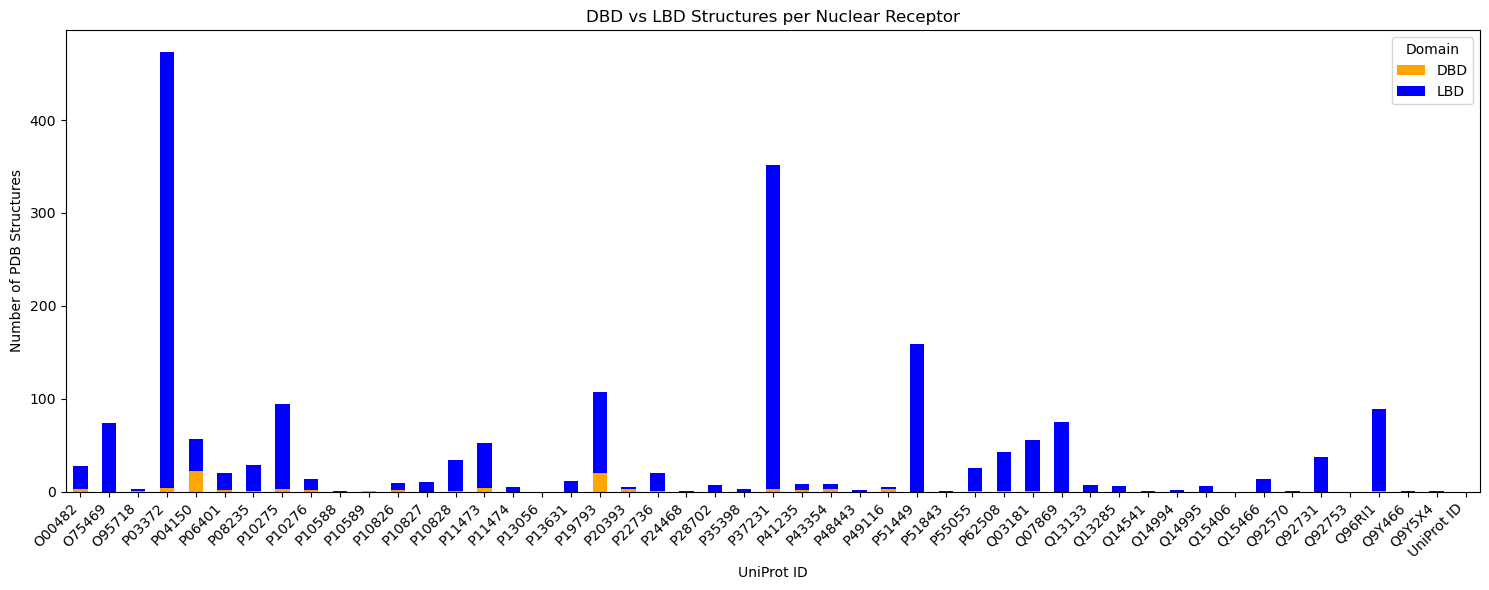

Total complexes with more than 2 unique polypeptide chains: 41


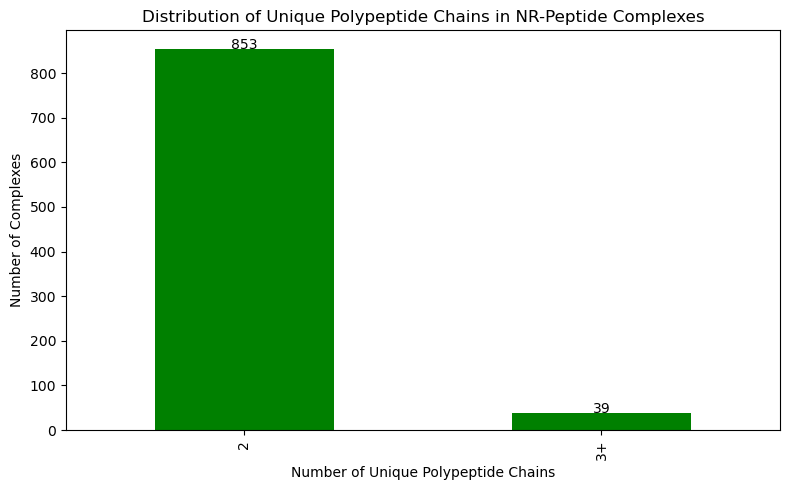

Visualizations displayed inline


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

# Visualization 1: DBD vs LBD Structures (from full_nr_structural_classification_report.txt)
# Since I can't access the file, using the provided data
data_csv = """UniProt ID   | Total Structures | DBD Count (w/ ZN) | LBD Count (no ZN)
O00482       | 28               | 3                 | 24
O75469       | 74               | 0                 | 74
O95718       | 3                | 1                 | 2
P03372       | 474              | 4                 | 469
P04150       | 57               | 22                | 35
P06401       | 20               | 2                 | 18
P08235       | 29               | 1                 | 28
P10275       | 94               | 3                 | 91
P10276       | 14               | 2                 | 12
P10588       | 1                | 0                 | 1
P10589       | 1                | 1                 | 0
P10826       | 9                | 2                 | 7
P10827       | 10               | 0                 | 10
P10828       | 34               | 1                 | 33
P11473       | 52               | 4                 | 48
P11474       | 5                | 0                 | 5
P13056       | 0                | 0                 | 0
P13631       | 11               | 0                 | 11
P19793       | 107              | 20                | 87
P20393       | 5                | 3                 | 2
P22736       | 20               | 1                 | 19
P24468       | 1                | 0                 | 1
P28702       | 7                | 0                 | 7
P35398       | 3                | 0                 | 3
P37231       | 353              | 3                 | 349
P41235       | 8                | 2                 | 6
P43354       | 8                | 3                 | 5
P48443       | 2                | 0                 | 2
P49116       | 5                | 3                 | 2
P51449       | 159              | 0                 | 159
P51843       | 1                | 0                 | 1
P55055       | 25               | 1                 | 24
P62508       | 43               | 1                 | 42
Q03181       | 55               | 1                 | 54
Q07869       | 75               | 0                 | 75
Q13133       | 7                | 0                 | 7
Q13285       | 6                | 0                 | 6
Q14541       | 1                | 0                 | 1
Q14994       | 2                | 0                 | 2
Q14995       | 6                | 0                 | 6
Q15406       | 0                | 0                 | 0
Q15466       | 13               | 0                 | 13
Q92570       | 1                | 0                 | 1
Q92731       | 37               | 0                 | 37
Q92753       | 0                | 0                 | 0
Q96RI1       | 89               | 1                 | 88
Q9Y466       | 1                | 0                 | 1
Q9Y5X4       | 1                | 0                 | 1
"""
try:
    # Replace with this line to read the actual file locally
    df = pd.read_csv('/Users/danamyktybek/Desktop/biol363_project/biol363/full_nr_structural_classification_report.txt',
                     sep='\s*\|\s*', engine='python', comment='#', skiprows=7,
                     names=['UniProt ID', 'Total Structures', 'DBD Count (w/ ZN)', 'LBD Count (no ZN)'])
    df.columns = df.columns.str.strip()
    df = df.dropna(subset=['UniProt ID', 'DBD Count (w/ ZN)', 'LBD Count (no ZN)'])
    df['DBD Count (w/ ZN)'] = pd.to_numeric(df['DBD Count (w/ ZN)'], errors='coerce').fillna(0).astype(int)
    df['LBD Count (no ZN)'] = pd.to_numeric(df['LBD Count (no ZN)'], errors='coerce').fillna(0).astype(int)
except Exception as e:
    print(f"Error reading file: {e}, using provided sample data")
    df = pd.read_csv(StringIO(data_csv), sep='\s*\|\s*', engine='python', comment='#')
    df.columns = df.columns.str.strip()

# Plot 1: Stacked Bar Chart for DBD vs LBD Structures
fig1, ax1 = plt.subplots(figsize=(15, 6))
df_plot = df.melt(id_vars='UniProt ID', value_vars=['DBD Count (w/ ZN)', 'LBD Count (no ZN)'],
                  var_name='Domain Type', value_name='Count')
df_plot['Domain'] = df_plot['Domain Type'].apply(lambda x: 'DBD' if 'DBD' in x else 'LBD')
df_pivot = df_plot.pivot(index='UniProt ID', columns='Domain', values='Count')
df_pivot.plot(kind='bar', stacked=True, ax=ax1, color={'DBD': 'orange', 'LBD': 'blue'})
ax1.set_title('DBD vs LBD Structures per Nuclear Receptor')
ax1.set_ylabel('Number of PDB Structures')
ax1.set_xlabel('UniProt ID')
ax1.legend(title='Domain')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization 2: Polypeptide Chain Distribution
# Sample data since nr_peptide_complexes_detailed.txt is not accessible
detailed_csv = """2HCD:
 - Entity 1: 250 AA, Desc: Vitamin D Receptor, Type: Receptor
 - Entity 2: 15 AA, Desc: SRC-1 peptide, Type: SRC-1
3A78:
 - Entity 1: 220 AA, Desc: Estrogen Receptor, Type: Receptor
 - Entity 2: 20 AA, Desc: NCoR peptide, Type: NCoR
 - Entity 3: 18 AA, Desc: Another coactivator, Type: SRC
"""
try:
    # Replace with this line to read the actual file locally
    with open('/Users/danamyktybek/Desktop/biol363_project/biol363/nr_peptide_complexes_detailed.txt', 'r') as f:
        detailed_lines = f.readlines()
except Exception as e:
    print(f"Error reading detailed file: {e}, using sample data")
    detailed_lines = detailed_csv.split('\n')

# Parse polypeptide counts
pdb_counts = {}
current_pdb = None
for line in detailed_lines:
    line = line.strip()
    if line.endswith(':') and '#' not in line:
        current_pdb = line[:-1]
        pdb_counts[current_pdb] = 0
    elif line.startswith('- Entity') and current_pdb:
        pdb_counts[current_pdb] += 1

# Calculate complexes with more than 2 polypeptide chains
num_more_than_2 = sum(1 for count in pdb_counts.values() if count > 2)
print(f"Total complexes with more than 2 unique polypeptide chains: {num_more_than_2}")

# Prepare data for visualization
counts_df = pd.DataFrame(list(pdb_counts.values()), columns=['Polypeptide Count'])
count_summary = counts_df['Polypeptide Count'].value_counts().sort_index()
# Filter for 2 or more polypeptides
count_summary = count_summary[count_summary.index >= 2]
count_summary = count_summary.reindex([2, 3], fill_value=0)
count_summary.index = [str(i) + ('+' if i == 3 else '') for i in count_summary.index]

# Plot 2: Bar Chart for Polypeptide Distribution
fig2, ax2 = plt.subplots(figsize=(8, 5))
count_summary.plot(kind='bar', ax=ax2, color='green')
ax2.set_title('Distribution of Unique Polypeptide Chains in NR-Peptide Complexes')
ax2.set_xlabel('Number of Unique Polypeptide Chains')
ax2.set_ylabel('Number of Complexes')
for i, v in enumerate(count_summary):
    ax2.text(i, v + 0.1, str(v), ha='center')
plt.tight_layout()
plt.show()

print("Visualizations displayed inline")

Total complexes with more than 2 unique polypeptide chains: 41


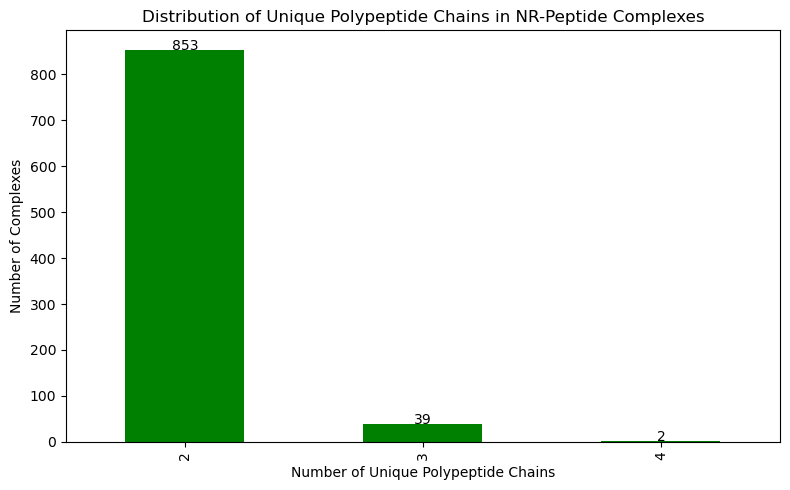

Visualization saved as 'nr_polypeptide_distribution.png'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the detailed output file generated by the main script
detailed_filename = "nr_peptide_complexes_detailed.txt"

# Parse the detailed file to count polypeptide chains per PDB ID
with open(detailed_filename, 'r') as f:
    lines = f.readlines()

pdb_counts = {}
current_pdb = None
for line in lines: 
    line = line.strip()
    if line.endswith(':') and '#' not in line:
        current_pdb = line[:-1]
        pdb_counts[current_pdb] = 0
    elif line.startswith('- Entity') and current_pdb:
        pdb_counts[current_pdb] += 1

# Calculate the number with more than 2 unique polypeptide chains
num_more_than_2 = sum(1 for count in pdb_counts.values() if count > 2)
print(f"Total complexes with more than 2 unique polypeptide chains: {num_more_than_2}")

# Prepare data for visualization
counts_df = pd.DataFrame(list(pdb_counts.values()), columns=['Polypeptide Count'])
count_summary = counts_df['Polypeptide Count'].value_counts().sort_index()

# Visualization: Bar chart
fig, ax = plt.subplots(figsize=(8, 5))
count_summary.plot(kind='bar', ax=ax, color='green')
ax.set_title('Distribution of Unique Polypeptide Chains in NR-Peptide Complexes')
ax.set_xlabel('Number of Unique Polypeptide Chains')
ax.set_ylabel('Number of Complexes')
for i, v in enumerate(count_summary):
    ax.text(i, v + 0.1, str(v), ha='center')
plt.tight_layout()
plt.savefig('nr_polypeptide_distribution.png')
plt.show()
print("Visualization saved as 'nr_polypeptide_distribution.png'")

In [10]:
#!/usr/bin/env python3
"""
NR-PEPTIDE FILTER FROM EXISTING LBD FOLDER
- Input: /Users/danamyktybek/Desktop/biol363_project/biol363/lbd_structures/*.xml
- Output: nr_peptide_complexes.txt, detailed.txt, reject_log.txt
- Fast, robust, parallel
"""

import os, sys, xml.etree.ElementTree as ET
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from typing import List, Optional, Tuple
from dataclasses import dataclass

# ------------------------------- CONFIG -------------------------------
LBD_DIR       = Path("/Users/danamyktybek/Desktop/biol363_project/biol363/lbd_structures")
DATA_DIR      = Path("nr_pipeline_data")

MIN_RECEPTOR = 50
MAX_PEPTIDE  = 49

# Known cofactors (UniProt → name)
KNOWN_COFACTORS = {
    "Q15788":"SRC-1","Q15596":"SRC-2","Q9Y6Q9":"SRC-3",
    "Q92793":"CBP","Q09472":"p300","O75376":"NCoR","Q9Y618":"SMRT"
}

# ------------------------------- HELPERS -------------------------------
def log(*a): print(*a, flush=True)
def mkdir(p): p.mkdir(parents=True, exist_ok=True)

def safe_text(elem, default=""):
    return elem.text.strip() if elem is not None and elem.text else default

# ------------------------------- CHAIN DATACLASS -------------------------------
@dataclass
class Chain:
    entity: str
    seq: str
    length: int
    desc: str
    uniprot: Optional[str]

# ------------------------------- PARSE XML (ROBUST) -------------------------------
def parse_xml(pdb: str) -> Tuple[List[Chain], str]:
    path = LBD_DIR / f"{pdb}.xml"
    if not path.exists():
        return [], f"{pdb}: XML MISSING"
    try:
        ns = {'pdbx': 'http://pdbml.pdb.org/schema/pdbx-v50.xsd'}
        root = ET.parse(path).getroot()
        chains = []
        title = safe_text(root.find(".//pdbx:struct_title", ns))
        for poly in root.findall(".//pdbx:entity_poly", ns):
            if safe_text(poly.find("pdbx:type", ns)) != "polypeptide(L)": continue
            eid = safe_text(poly.find("pdbx:entity_id", ns))
            if not eid: continue
            seq_el = poly.find("pdbx:pdbx_seq_one_letter_code_can", ns) or poly.find("pdbx:pdbx_seq_one_letter_code", ns)
            seq = safe_text(seq_el).replace("\n","").replace(" ","")
            if not seq: continue
            desc = safe_text(root.find(f".//pdbx:entity[@id='{eid}']/pdbx:pdbx_description", ns), "N/A")
            up_el = root.find(f".//pdbx:entity[@id='{eid}']/pdbx:db_reference[@db='UniProt']", ns)
            up = up_el.get("id") if up_el is not None else None
            chains.append(Chain(eid, seq, len(seq), desc, up))
        return chains, title
    except Exception as e:
        return [], f"{pdb}: PARSE ERROR – {e}"

# ------------------------------- FRAGMENT CHECK -------------------------------
def is_fragment(short: str, long_seq: str) -> bool:
    return short in long_seq

# ------------------------------- PROCESS ONE PDB -------------------------------
REJECT_LOG = []

def process_pdb(pdb: str) -> Optional[str]:
    global REJECT_LOG
    chains, title = parse_xml(pdb)
    if not chains:
        REJECT_LOG.append(f"{pdb}: no chains parsed")
        return None

    recs = [c for c in chains if c.length >= MIN_RECEPTOR]
    peps = [c for c in chains if c.length <= MAX_PEPTIDE]

    if not recs:
        REJECT_LOG.append(f"{pdb}: no receptor (>= {MIN_RECEPTOR} AA)")
        return None
    if not peps:
        REJECT_LOG.append(f"{pdb}: no peptide (<= {MAX_PEPTIDE} AA)")
        return None

    valid_peps = []
    for p in peps:
        if any(is_fragment(p.seq, r.seq) for r in recs):
            REJECT_LOG.append(f"{pdb}: peptide {p.entity} is substring of receptor")
        else:
            valid_peps.append(p)

    if not valid_peps:
        REJECT_LOG.append(f"{pdb}: all peptides are fragments")
        return None

    # Build detailed output
    lines = [f"{pdb}:"]
    for r in recs:
        cof = KNOWN_COFACTORS.get(r.uniprot, "Receptor")
        lines.append(f"  - Entity {r.entity}: {r.length} AA | {r.desc} | {r.uniprot or '-'} ({cof})")
    for p in valid_peps:
        cof = KNOWN_COFACTORS.get(p.uniprot, "Unknown")
        lines.append(f"  - Entity {p.entity}: {p.length} AA | {p.desc} | {p.uniprot or '-'} ({cof})")
    lines.append("")
    return "\n".join(lines)

# ------------------------------- MAIN -------------------------------
def main():
    log("="*60)
    log("NR-PEPTIDE FILTER FROM LBD FOLDER")
    log("="*60)

    if not LBD_DIR.exists():
        log(f"ERROR: {LBD_DIR} not found!")
        sys.exit(1)

    xml_files = [f.stem.upper() for f in LBD_DIR.glob("*.xml")]
    log(f"Found {len(xml_files)} XML files in {LBD_DIR}")

    mkdir(DATA_DIR)

    log("Filtering complexes (parallel)…")
    results = []
    with ThreadPoolExecutor(16) as ex:
        for i, res in enumerate(ex.map(process_pdb, xml_files)):
            if res:
                results.append(res)
            if i % 100 == 0:
                log(f"  processed {i}/{len(xml_files)} | kept {len(results)}")

    # Write outputs
    complexes = [r.splitlines()[0][:-1] for r in results]
    detailed = "\n".join(results)

    (DATA_DIR / "nr_peptide_complexes.txt").write_text("\n".join(complexes))
    (DATA_DIR / "nr_peptide_complexes_detailed.txt").write_text(detailed)
    (DATA_DIR / "reject_log.txt").write_text("\n".join(REJECT_LOG))

    log("\nDONE!")
    log(f"  {len(complexes)} valid NR-peptide complexes")
    log(f"  {len(REJECT_LOG)} rejected → see reject_log.txt")
    log(f"  Results in {DATA_DIR}")

if __name__ == "__main__":
    main()

NR-PEPTIDE FILTER FROM LBD FOLDER
Found 1845 XML files in /Users/danamyktybek/Desktop/biol363_project/biol363/lbd_structures
Filtering complexes (parallel)…
  processed 0/1845 | kept 0
  processed 100/1845 | kept 0
  processed 200/1845 | kept 0
  processed 300/1845 | kept 0
  processed 400/1845 | kept 0
  processed 500/1845 | kept 0
  processed 600/1845 | kept 0
  processed 700/1845 | kept 0
  processed 800/1845 | kept 0
  processed 900/1845 | kept 0
  processed 1000/1845 | kept 0
  processed 1100/1845 | kept 0
  processed 1200/1845 | kept 0
  processed 1300/1845 | kept 0
  processed 1400/1845 | kept 0
  processed 1500/1845 | kept 0
  processed 1600/1845 | kept 0
  processed 1700/1845 | kept 0
  processed 1800/1845 | kept 0

DONE!
  0 valid NR-peptide complexes
  1845 rejected → see reject_log.txt
  Results in nr_pipeline_data
